<br><font size=8 color='navy'>Network Intrusion Detection Using DNN</font>

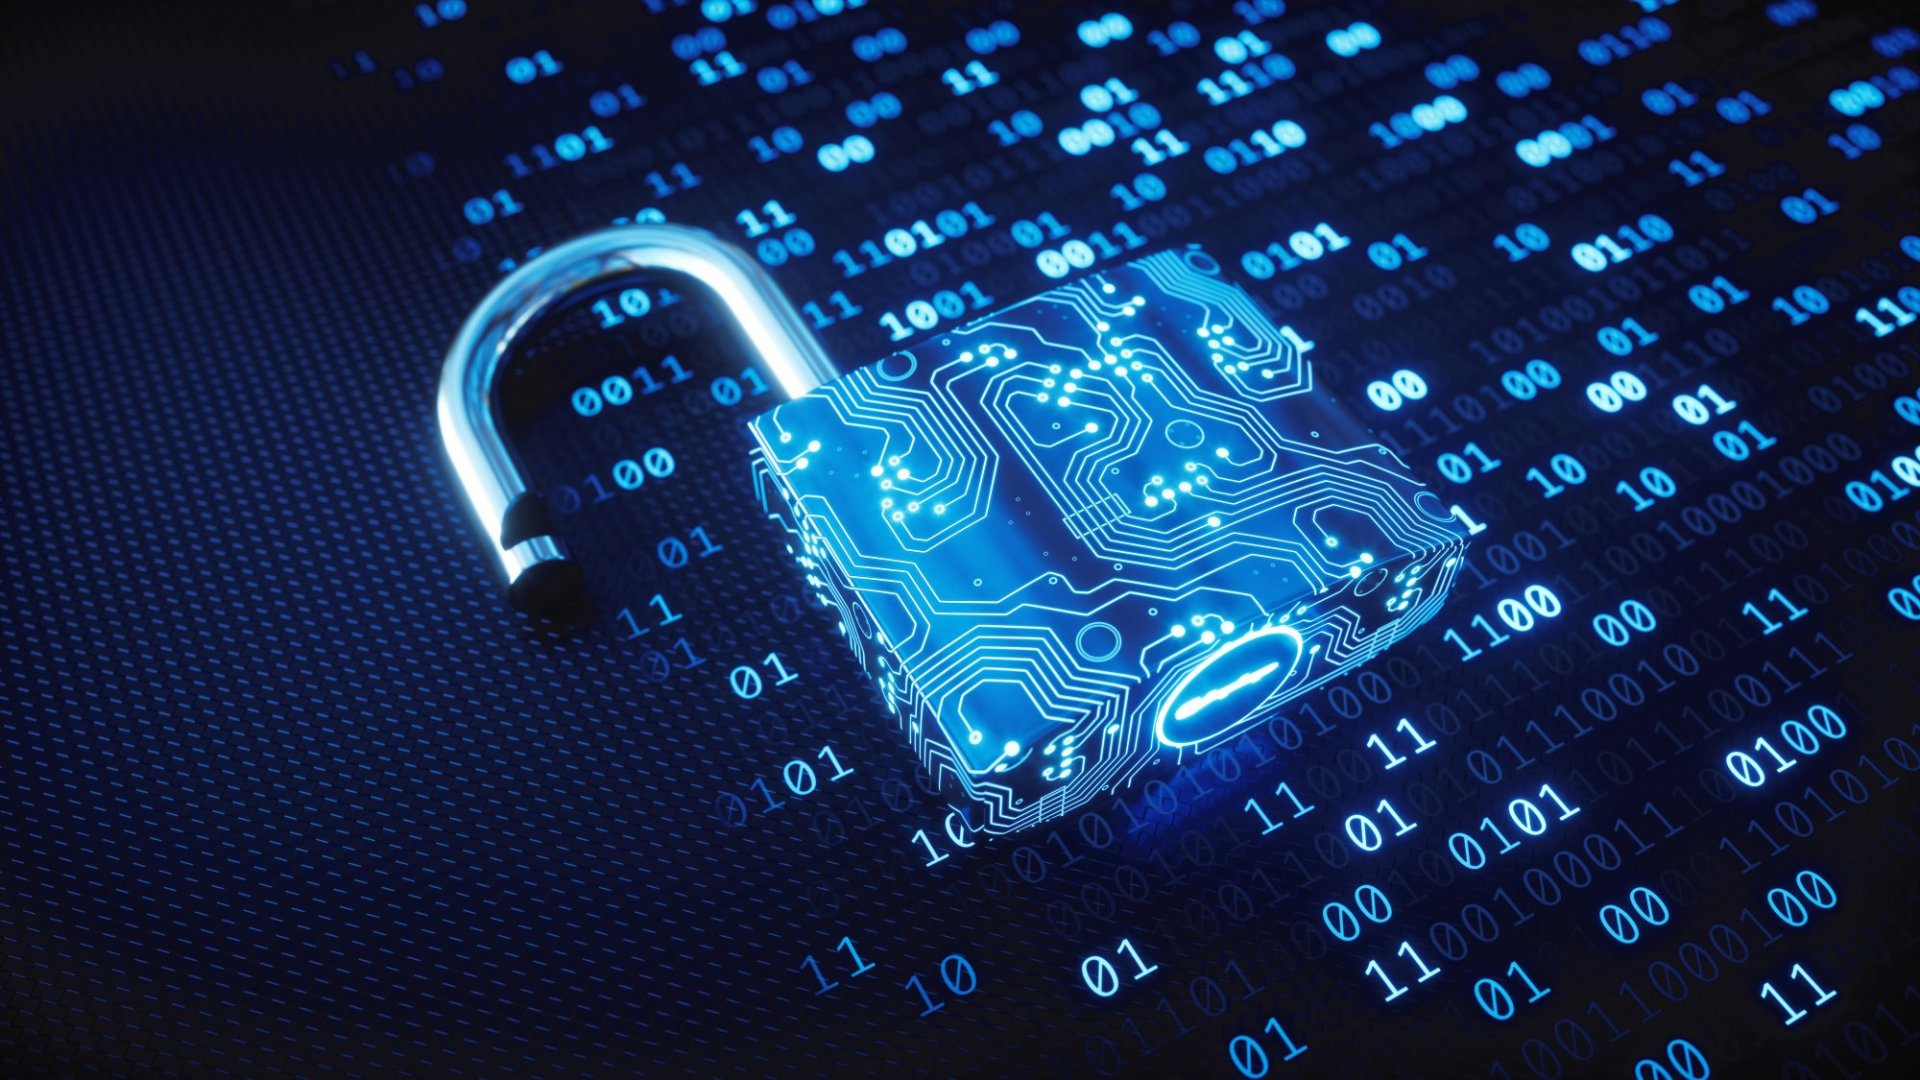

# <font color='navy'>Problem Statement</font>

<font color='navy'><b><u>Background Information</u>:<br>
This dataset (https://www.kaggle.com/datasets/solarmainframe/ids-intrusion-csv) was originally created by the University of New Brunswick for analyzing DDoS data. The dataset itself was based on logs of the university's servers, which found various DoS attacks throughout the publicly available period. Data is divided into various files based on date.</font> 

<font color='navy'><b><u>Objective</u>:</b><br>
<b>We need to create a deep learning based model which determines which of the logs are network intrusions</b></font>

# <font color='navy'>Loading the dependencies</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
# peeking the list of files
file_list = glob('*\*.csv')
file_list

['Dataset\\02-14-2018.csv',
 'Dataset\\02-15-2018.csv',
 'Dataset\\02-16-2018.csv',
 'Dataset\\02-20-2018.csv',
 'Dataset\\02-21-2018.csv',
 'Dataset\\02-22-2018.csv',
 'Dataset\\02-23-2018.csv',
 'Dataset\\02-28-2018.csv',
 'Dataset\\03-01-2018.csv',
 'Dataset\\03-02-2018.csv']

# <font color='navy'>Analyzing all the above files</font>
<b><font color='navy'>We use the term 'Benign' to refer to normal logs and 'Malicious' to refer to all other non-benign logs collectively</font></b>

In [3]:
# total number of datapts combining all files
rows = 0

# capturing the shape of each file
shapes = []

# capturing the number of benign and malicious logs in each file
benign_malicious_tuple = []  

# total number of datapts after downsampling the dominant class in each file
downsampled_data = 0  

# total number of benign and malicious cases
benign_cases, malicious_cases = 0, 0

for file in file_list:
    tmp = pd.read_csv(file)
    shape = tmp.shape
    rows += shape[0]
    shapes.append(shape)
    no_benign = (tmp.Label == 'Benign').sum()
    no_malicious = shape[0] - no_benign
    benign_malicious_tuple.append((no_benign, no_malicious))
    downsampled_data += (2 * min(no_benign, no_malicious))
    benign_cases += no_benign
    malicious_cases += no_malicious
    
print(f'Total number of rows = {rows}\n')
print(f'Shapes of each file are {shapes}\n')
print(f'benign_malicious_tuple are {benign_malicious_tuple}\n')
print(f'Total number of datapts after downsampling = {downsampled_data}\n')
print(f'Total number of benign and malicious cases are {benign_cases} & {malicious_cases} respectively')

Total number of rows = 16233002

Shapes of each file are [(1048575, 80), (1048575, 80), (1048575, 80), (7948748, 84), (1048575, 80), (1048575, 80), (1048575, 80), (613104, 80), (331125, 80), (1048575, 80)]

benign_malicious_tuple are [(667626, 380949), (996077, 52498), (446772, 601803), (7372557, 576191), (360833, 687742), (1048213, 362), (1048009, 566), (544200, 68904), (238037, 93088), (762384, 286191)]

Total number of datapts after downsampling = 4532708

Total number of benign and malicious cases are 13484708 & 2748294 respectively


# <font color='navy'><b>Observations</b></font>
- <font color='navy'><b>There are 16million+ datapoints in total</b></font>
- <font color='navy'><b>4th file alone has 4 extra features</b></font>
- <font color='navy'><b>Even if we downsample using the minimum approach, we'd still have 4.5million+ datapoints</b></font>
- <font color='navy'><b>Dataset is highly imbalanced, we have 5 times as many benign cases as all malicious cases combined</b></font>

# <font color='navy'><b>Remedial Measures</b></font>
- <font color='navy'><b>Ignore the 4 extra features in the 4th file</b></font>
- <font color='navy'><b>First we downsample from 16million+ to 4.5million+ datapoints, from which we further randomly selected exactly 2.5million datapoints</b></font>
- <font color='navy'><b>2.5million will give us round 2million for train and 0.5million validation & test combined</b></font>
- <font color='navy'><b>We select the above 2.5million points by stratifying over benignity</b></font>
- <font color='navy'><b>We're converting this problem into a Binary Classification problem</b></font>

In [4]:
# if the combined data file did not exist
if not os.path.isfile('combined_data.csv'):
    # creating a dataframe to gather the datapoints from all the above files
    tmp = pd.DataFrame()

    # required columns 
    cols = pd.read_csv(file_list[0]).columns

    # iterating over all files in the list
    for file in file_list:

        # reading and converting the file into df
        tmp_file = pd.read_csv(file, usecols=cols)
        
        # choosing benign data and malicious data
        benign_data = tmp_file[tmp_file.Label=='Benign']
        malicious_data = tmp_file[tmp_file.Label!='Benign']
        
        # capturing the number of datapoints in each df
        ben_no, mal_no = benign_data.shape[0], malicious_data.shape[0]
        
        # downsampling the benign_data if benign is more
        if ben_no >= mal_no:
            benign_data = benign_data.sample(n=mal_no)
            
        # downsampling the malicious_data if malicious is more
        else:
            malicious_data = malicious_data.sample(n=ben_no)
                
        # concatenating the above dfs with the main df
        tmp = pd.concat([tmp, benign_data, malicious_data], axis=0, ignore_index=True)
    
    # filtering 1.25million 'Benign' cases and 1.25million 'Malicious' cases
    tmp_benign = tmp[tmp.Label=='Benign'].sample(n=1250000)
    tmp_malicious = tmp[tmp.Label!='Benign'].sample(n=1250000)
    
    # concatenating the above two dfs to form a final df
    final = pd.concat([tmp_benign, tmp_malicious], axis=0, ignore_index=True)
    
    # shuffling the above final df 
    final = final.sample(frac=1)
    
    # saving the df onto a csv file
    final.to_csv('combined_data.csv')

# <font color='navy'>EDA</font>

In [5]:
# reading and converting the combined_data.csv into a dataframe
df = pd.read_csv('combined_data.csv')

In [6]:
# checking the data dimensions
df.shape

(2500000, 81)

In [7]:
# checking the columns
df.columns

Index(['Unnamed: 0', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
       'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean',
       'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio',
       '

In [8]:
# peek into the dataframe
df.head()

,Unnamed: 0,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,333056,57049,6,21/02/2018 02:33:08,1717,5,2,935.0,314.0,935.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,394094,443,6,14/02/2018 11:29:12,117315366,15,15,1200.0,3843.0,553.0,...,20,280731.5,176314.954569,405405.0,156058.0,58300108.0,357629.15408,58552990.0,58047226.0,Benign
2,1122503,443,6,20/02/2018 02:20:02,93531,2,1,74.0,126.0,74.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,870062,64913,6,21/02/2018 02:30:16,17826,5,2,935.0,273.0,935.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,175543,53,17,02/03/2018 01:02:18,1819,1,1,41.0,127.0,41.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


<font color='navy'><b>The first column 'Unnamed: 0' is basically the index from the each of the separate files, we can drop this first column as pandas default indexing is good enough</b></font>

In [9]:
df.drop('Unnamed: 0', axis=1, inplace=True)

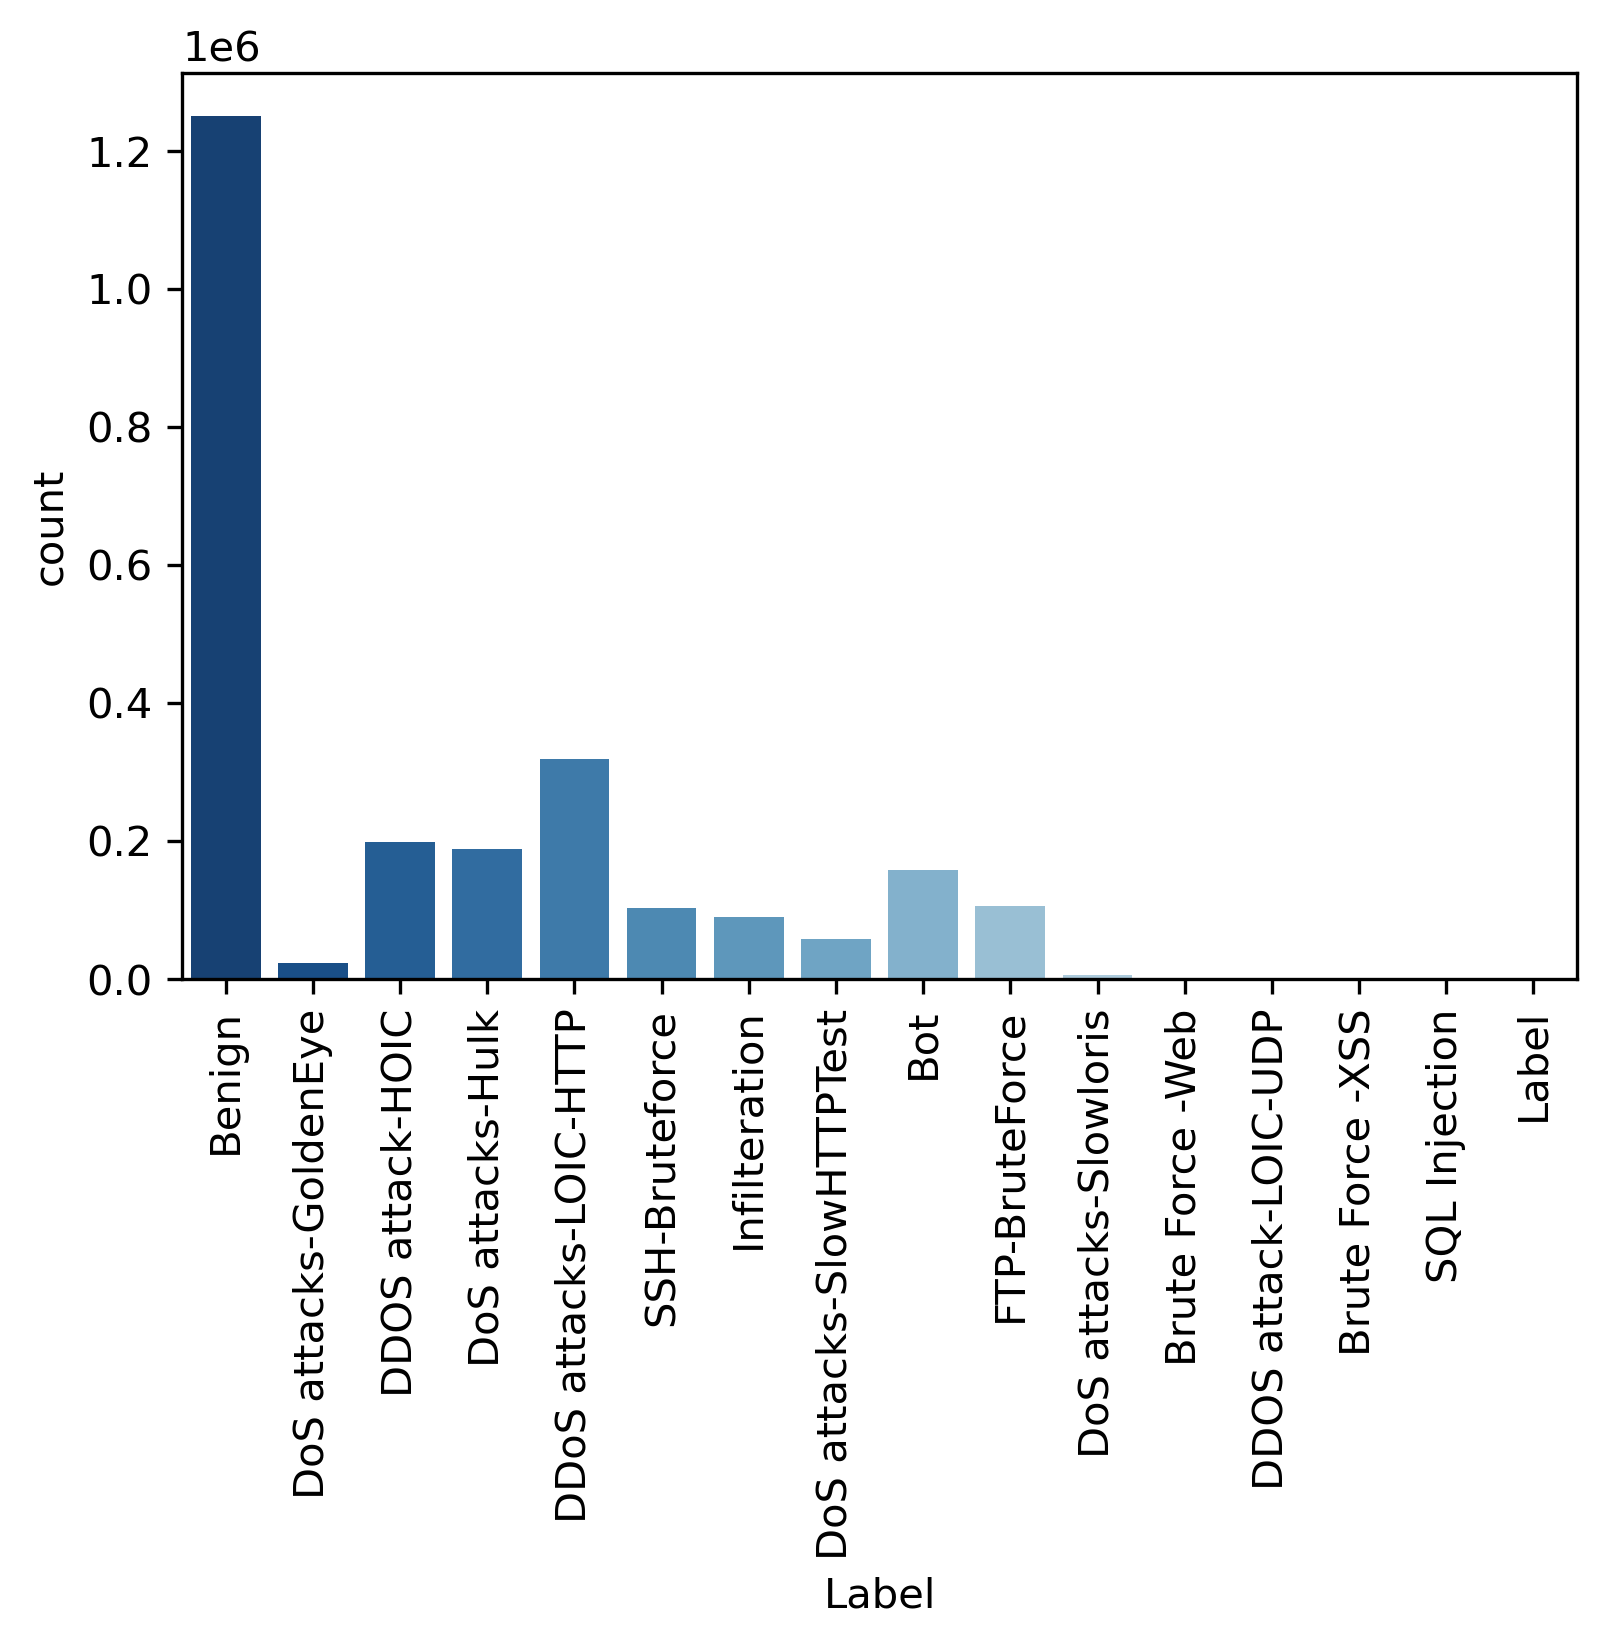

In [10]:
# checking the distribution of the data using the 'Label'
plt.figure(dpi=300)
sns.countplot(df.Label, palette='Blues_r')
plt.xticks(rotation=90);

<font color='navy'><b>The data distribution is clearly imbalanced if we consider each type of 'Malicious' log as a separate category. But we're going to combine all the types of 'Malicious' logs as one kind and numerically encode the whole dataframe with 0 for 'Benign' and 1 for 'Malicious'. It will make our dataset perfectly balanced by its very design and we can solve it as a Binary Classification problem.</b></font>

In [11]:
# encoder function
def encoding(label):
    if label == 'Benign':
        return 0
    return 1

In [12]:
df.Label = df.Label.apply(encoding)

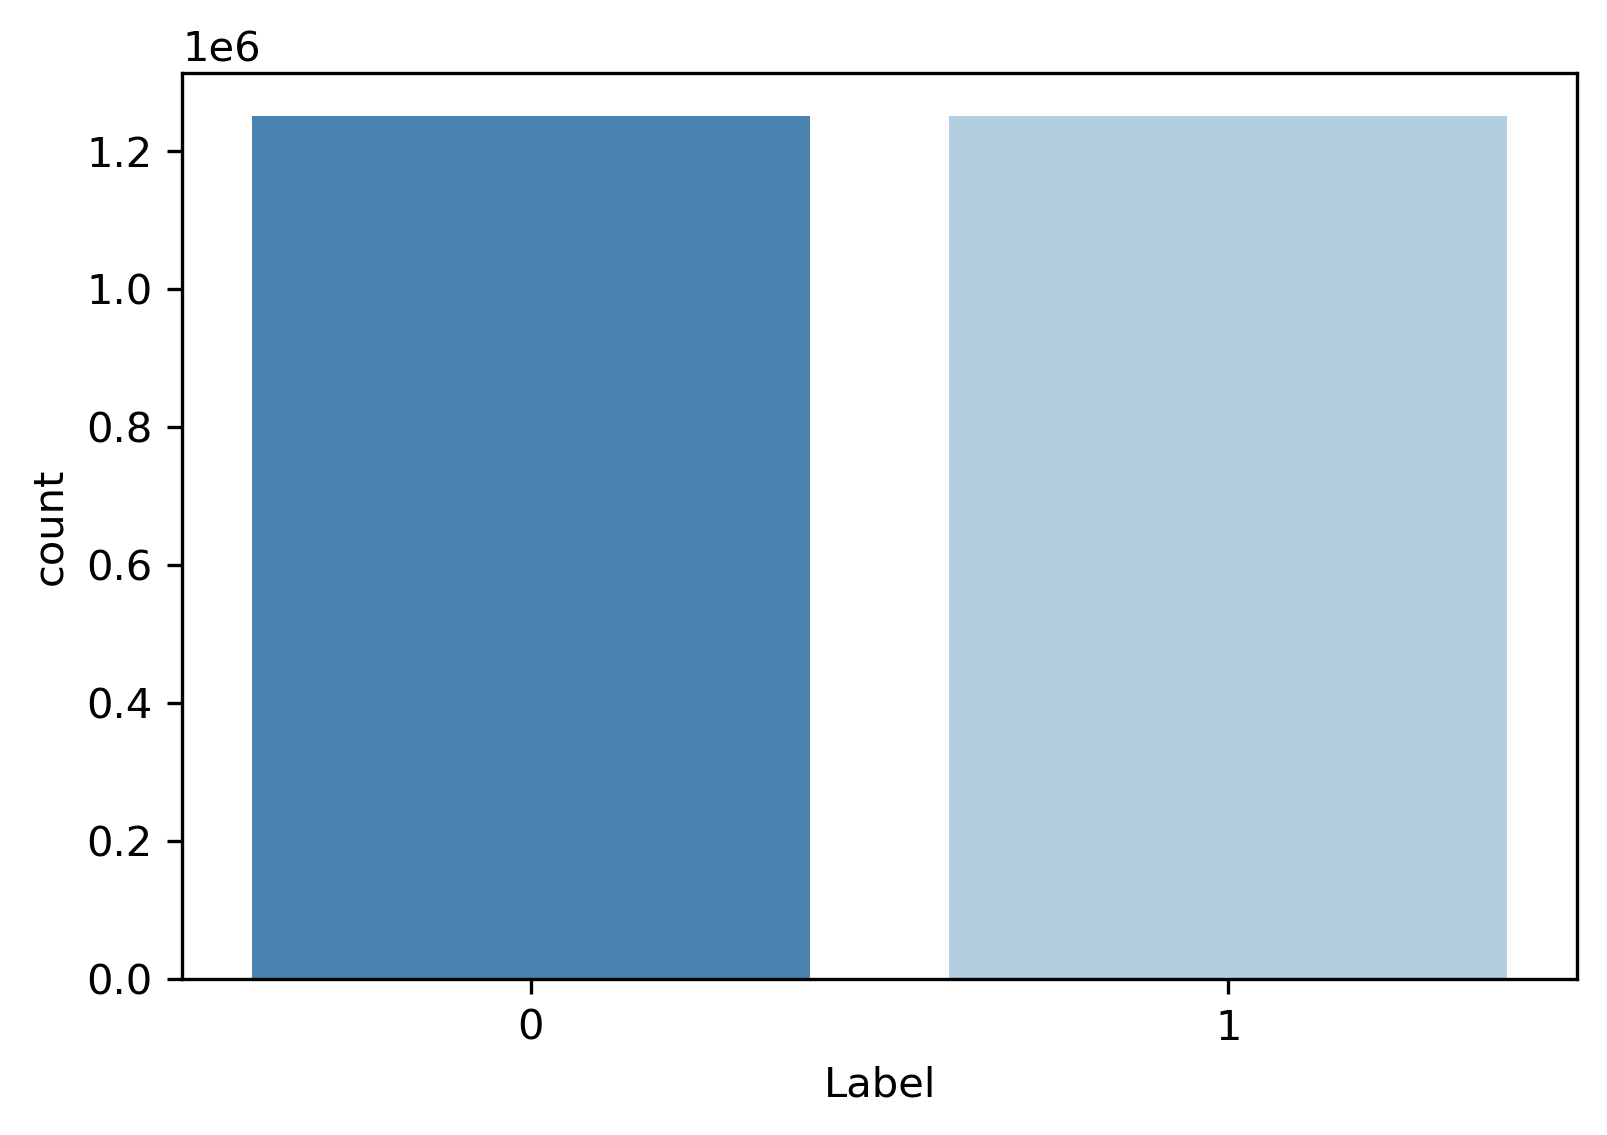

In [13]:
# checking the distribution of the data using the 'Label'
plt.figure(dpi=300)
sns.countplot(df.Label, palette='Blues_r');

<font color='navy'><b>The above plot shows that our dataset is now perfectly balanced between 'Benign' or 0 class and 'malicious' or 1 class</b></font>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 80 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Dst Port           object
 1   Protocol           object
 2   Timestamp          object
 3   Flow Duration      object
 4   Tot Fwd Pkts       object
 5   Tot Bwd Pkts       object
 6   TotLen Fwd Pkts    object
 7   TotLen Bwd Pkts    object
 8   Fwd Pkt Len Max    object
 9   Fwd Pkt Len Min    object
 10  Fwd Pkt Len Mean   object
 11  Fwd Pkt Len Std    object
 12  Bwd Pkt Len Max    object
 13  Bwd Pkt Len Min    object
 14  Bwd Pkt Len Mean   object
 15  Bwd Pkt Len Std    object
 16  Flow Byts/s        object
 17  Flow Pkts/s        object
 18  Flow IAT Mean      object
 19  Flow IAT Std       object
 20  Flow IAT Max       object
 21  Flow IAT Min       object
 22  Fwd IAT Tot        object
 23  Fwd IAT Mean       object
 24  Fwd IAT Std        object
 25  Fwd IAT Max        object
 26  Fwd IAT Min   

# <font color='navy'>Feature Engineering</font>
<font color='navy'><b>Except for the numerically encoded feature of 'Label', all other features are of Object dtype, however it cannot be the case. We're going to further analyze these columns.<br>
    
Since the university's serves classifies traffic as both forward and backward, there are columns for both. According to the data source, the most important columns within this dataset are listed below.<br><br>

- Dst Port (Destination port)
- Protocol
- Flow Duration
- Tot Fwd Pkts (Total forward packets)
- Tot Bwd Pkts (Total backward packets)
- Label

Hence we're going to build a Deep Neural Network model using the above features only.</b></font>

In [15]:
df.Protocol.value_counts()

6           1965618
17           257382
6            229902
17            30374
0             14856
0              1836
Protocol         32
Name: Protocol, dtype: int64

In [16]:
df[df.Protocol == 'Protocol'].head(2)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
181434,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,1
374147,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,1


In [17]:
df = df[df.Protocol != 'Protocol']

<font color='navy'><b>Clearly we can observe that the classes 0, 6, 17 are occuring twice, it must be a mistake where in one instance it is int version and another instance it is string version of the same value. This needs to corrected. Also we're dropping those rows with value itself as the string 'Protocol'.</b></font>

In [18]:
# converting int classes to strings
df.Protocol = df.Protocol.apply(lambda x: 'Protocol_'+str(x))

<font color='navy'><b>After all the aforementioned corrections, 'Protocol' is the categorical variable which needs to be OneHotEncoded and the remaining features are numerical features which we're going to normalize for faster convergence</b></font>

In [19]:
# instantiating OneHotEncoder and MinMaxScaler

ohe = OneHotEncoder()

norm = MinMaxScaler()

In [20]:
# columns to be OneHotEncoded
ohe_cols = ['Protocol']

# columns to be normalized
norm_cols = ['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts']

# Note: all other columns not listed above will be dropped automatically

In [21]:
# instantiating column transformers
ct = make_column_transformer((ohe, ohe_cols),
                             (norm, norm_cols),
                             remainder='drop')

In [22]:
# reshuffle the whole dataframe
df = df.sample(frac=1)

In [23]:
# separating independent and dependent variables
X = df.drop('Label', axis=1)
y = df.Label

In [24]:
# train, validation and test split
X_train, y_train = X[:2000000], y[:2000000]
X_val, y_val = X[2000000:2250000], y[2000000:2250000]
X_test, y_test = X[2250000:], y[2250000:]

In [25]:
# applying the column transformers by fitting and transforming on the training set
X_train_trans = ct.fit_transform(X_train)

# only transforming on the validation and testing set based on the above fit
X_val_trans = ct.transform(X_val)
X_test_trans = ct.transform(X_test)

# <font color='navy'>Building Deep Neural Network Model</font>

In [26]:
# knobs and dials for the deep neural network
eta = 0.01
epochs = 20
batch = 512
verbose = 1

In [27]:
# instantiating the Sequential API
dnn = Sequential()

# adding hidden layers and output layer 
dnn.add(Dense(10, activation='relu'))
dnn.add(Dense(20, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))

# compiling the model
dnn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=eta),
            metrics='accuracy')

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: eta / 10**(np.floor(4*x/epochs)))

# fitting the dnn on the training data and simultaneously evaluating it on the validation data
dnn_history = dnn.fit(X_train_trans, y_train,
                    epochs=epochs,
                    batch_size=batch,
                    validation_data=[X_val_trans, y_val],
                    callbacks=[lr_scheduler],
                    verbose=verbose)

Epoch 1/20
3907/3907 [==============================] - 10s 2ms/step - loss: 0.4353 - accuracy: 0.8157 - val_loss: 0.3540 - val_accuracy: 0.8722 - lr: 0.0100
Epoch 2/20
3907/3907 [==============================] - 10s 2ms/step - loss: 0.2685 - accuracy: 0.9155 - val_loss: 0.2507 - val_accuracy: 0.9213 - lr: 0.0100
Epoch 3/20
3907/3907 [==============================] - 10s 2ms/step - loss: 0.2529 - accuracy: 0.9215 - val_loss: 0.2784 - val_accuracy: 0.9261 - lr: 0.0100
Epoch 4/20
3907/3907 [==============================] - 9s 2ms/step - loss: 0.2511 - accuracy: 0.9222 - val_loss: 0.2467 - val_accuracy: 0.9215 - lr: 0.0100
Epoch 5/20
3907/3907 [==============================] - 9s 2ms/step - loss: 0.2492 - accuracy: 0.9224 - val_loss: 0.2449 - val_accuracy: 0.9215 - lr: 0.0100
Epoch 6/20
3907/3907 [==============================] - 9s 2ms/step - loss: 0.2432 - accuracy: 0.9240 - val_loss: 0.2414 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 7/20
3907/3907 [==============================] -

In [28]:
# viewing the network architecture
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                80        
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


# <font color='navy'>Evaluating the dnn Model on the balanced unseen test data set</font>

In [29]:
# evaluating on the test set
dnn.evaluate(X_test_trans, y_test, batch_size=2**12)

62/62 [==============================] - 0s 2ms/step - loss: 0.2378 - accuracy: 0.9254


[0.23780901730060577, 0.925370454788208]

In [30]:
# making predictions using the test set
y_proba = dnn.predict(X_test_trans, batch_size=2**12)
y_pred = np.round(y_proba.reshape(-1,))

62/62 [==============================] - 0s 947us/step


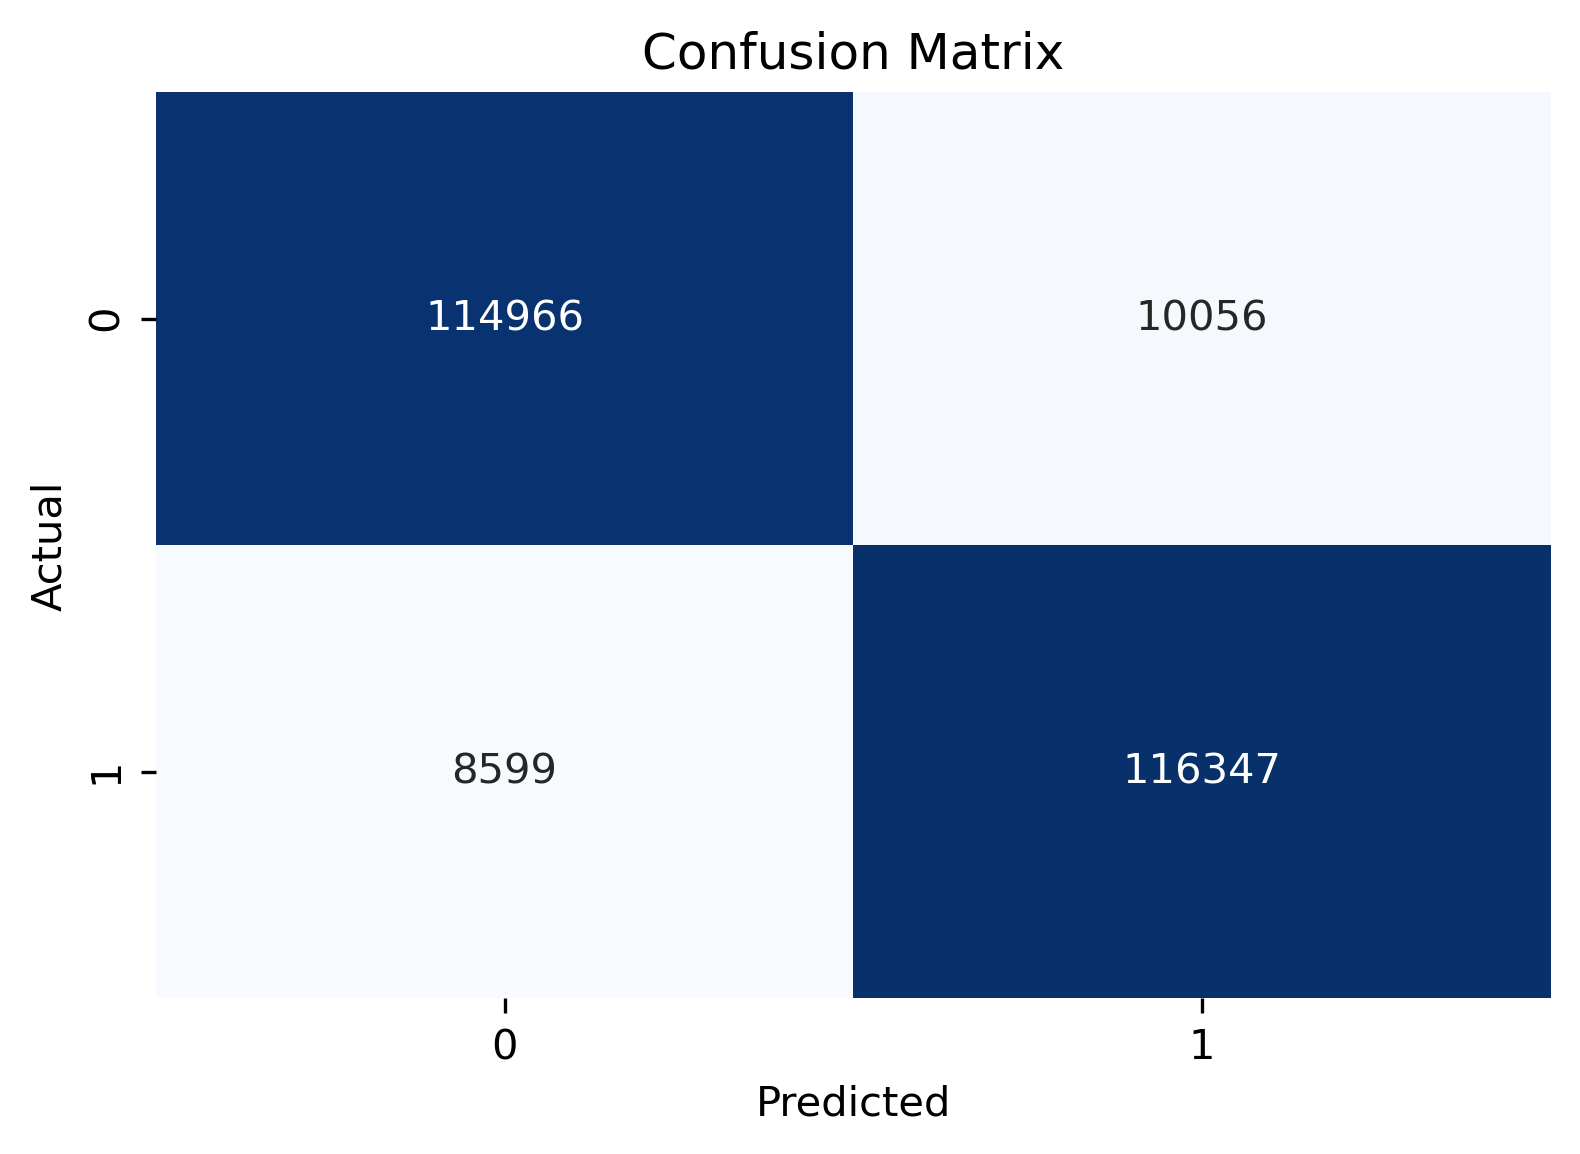

In [31]:
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False, cmap='Blues', fmt='.6g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix");

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92    125022
           1       0.92      0.93      0.93    124946

    accuracy                           0.93    249968
   macro avg       0.93      0.93      0.93    249968
weighted avg       0.93      0.93      0.93    249968



In [33]:
print(f'Accuracy score of the model is {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'Precision score of the model is {round(100*precision_score(y_test, y_pred),2)}%')
print(f'Recall score of the model is {round(100*recall_score(y_test, y_pred),2)}%')
print(f'f1 score of the model is {round(100*f1_score(y_test, y_pred),2)}%')

Accuracy score of the model is 92.54%
Precision score of the model is 92.04%
Recall score of the model is 93.12%
f1 score of the model is 92.58%


# <font color='navy'>Evaluating the dnn Model on the entirety of the 16million+ imbalanced data set</font>

<font color='navy'><b>Here we are creating a UDF which take in 2 arguments, one is the trained neural network model and the other is the filepath of the dataset. This function will apply convert the .csv file in the provided filepath into a dataframe and apply necessary encoding & transformations and then evaluate the performance of the trained model which we passed in as the first argument.</b></font>

In [34]:
def performance_on_files(model, file_path):
    # converting the .csv file in to a dataframe
    new_df = pd.read_csv(file_path)
    
    # encoding the 'Label' feature
    new_df.Label = new_df.Label.apply(encoding)
    
    # dropping few irrelevant rows based on 'Protocol'
    if (new_df.Protocol == 'Protocol').sum() > 0:
        new_df = new_df[new_df.Protocol != 'Protocol']
    
    # encoding 'Protocol' feature
    if set(new_df.Protocol.value_counts().index)!= {'0', '6', '17'}:
        new_df.Protocol = new_df.Protocol.apply(lambda x: 'Protocol_'+str(x))
    
    # separating independent and dependent variables
    X_new = new_df.drop('Label', axis=1)
    y_new = new_df.Label
    
    # applying the already fit column transform method
    X_new_trans = ct.transform(X_new)
    
    # making predictions using the above set
    y_new_proba = model.predict(X_new_trans, batch_size=2**12)
    y_new_pred = np.round(y_new_proba.reshape(-1,))
    
    # calculating all relevant classification metrics
    acc = accuracy_score(y_new, y_new_pred)
    prec = precision_score(y_new, y_new_pred)
    rec = recall_score(y_new, y_new_pred)
    f1 = f1_score(y_new, y_new_pred)
    
    # returning the above metrics as tuple
    return [acc, prec, rec, f1]

In [35]:
accuracy, precision, recall, f_one = 0, 0, 0, 0 

# iterating over the original file_list provided
for file in file_list:
    
    # using the above UDF to obtain the metrics for each of the file
    acc, prec, rec, f1 = performance_on_files(dnn, file)
    
    # increment the metrics in their respective variables and then we'll average them out
    accuracy += acc
    precision += prec
    recall += rec
    f_one += f1

256/256 [==============================] - 0s 1ms/step


In [36]:
print(f'Accuracy score of the model is {round(10*accuracy,2)}%')
print(f'Precision score of the model is {round(10*precision,2)}%')
print(f'Recall score of the model is {round(10*recall,2)}%')
print(f'f1 score of the model is {round(10*f_one,2)}%')

Accuracy score of the model is 87.65%
Precision score of the model is 46.76%
Recall score of the model is 73.08%
f1 score of the model is 49.09%


# <font color='navy'><u>dnn model Performance Report</u></font>

<font color='navy'><b>Note: Usually in this type of cyber security model, recall (alongside accuracy) is the most important metric</b></font>

# <font color='navy'><b>Downsampled Balanced Dataset</b></font>
- <font color='navy'><b>Number of datapoints = 2.5million</b></font>
- <font color='navy'><b>Accuracy = 93%</b></font>
- <font color='navy'><b>Recall = 93%</b></font>

# <font color='navy'><b>Entirety of Highly Imbalanced Dataset</b></font>
- <font color='navy'><b>Number of datapoints = 16million+</b></font>
- <font color='navy'><b>Accuracy = 88%</b></font>
- <font color='navy'><b>Recall = 73%</b></font>